In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

Using TensorFlow backend.


In [2]:
# This function lists out all permutations of ace values in the array sum_array
# For example, if you have 2 aces, there are 4 permutations:
#     [[1,1], [1,11], [11,1], [11,11]]
# These permutations lead to 3 unique sums: [2, 12, 22]
# Of these 3, only 2 are <=21 so they are returned: [2, 12]
def get_ace_values(ace_list):
    sum_array = np.zeros((2*len(ace_list), len(ace_list)))
    # This loop gets the permutations
    for i in range(len(ace_list)):
        n = len(ace_list) - i
        half_len = int(2 ** n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)):
            sum_array[rep *2**n: rep * 2**n + half_len, i] = 1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    # return values that are valid (<=21)
    return list(set([int(s) for s in np.sum(sum_array, axis=1) if s<=21]))

# Convert num_aces, an int to a list of lists
# For example if num_aces=2, the output should be [[1,11],[1,11]]
def ace_values(num_aces):
    ace_list = []
    for i in range(num_aces):
        ace_list.append([1,11])
    return get_ace_values(ace_list)

In [6]:
# generate a deck
# card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]
def generate_decks(num_decks, card_types):
    deck = []
    for i in range(num_decks):
        for j in range(4):
            deck.extend(card_types)
    random.shuffle(deck)
    return deck

In [8]:
# sum up value of hand card
def sum_up(hand):
    num_aces = 0 #num of aces
    total = 0  #total score
    for card in hand:
        if card != 'A':
            total += card  #if the card is not 'A', get the face value
        else:
            num_aces += 1  #how many aces does the hand card have
    # Call function ace_values to produce list of possible values for aces in hand
    ace_value_list = ace_values(num_aces) #get ace value from this hand of aces
    final_totals = [i+total for i in ace_value_list if i+total<=21]  # total score in the hand
    
    if final_totals == []:
        if ace_value_list == []:
            return total
        else:
            return min(ace_value_list) + total
    else:
        return max(final_totals)

In [9]:
# Play a game of blackjack (after the cards are dealt)
# blackjack = set(['A',10])
#1 check dealer_card == blackjack? yes, check player blackjack? player blackjack yes(0) no(player -1)
#2 check player blackjack? yes player win
def play_game(dealer_hand, player_hands, blackjack, curr_player_results, dealer_cards, hit_stand):
    action = 0
    # Dealer checks for 21
    if set(dealer_hand) == blackjack:
        for player in range(players):
            if set(player_hands[player]) != blackjack:
                curr_player_results[0,player] = -1 #player lose
            else:
                curr_player_results[0,player] = 0 # both have blackjack 
    else:
        for player in range(players):
            # Players check for 21
            if set(player_hands[player]) == blackjack:
                curr_player_results[0,player] = 1  #player lose
            else:
                # Hit randomly, check for busts
                if (hit_stand >= 0.5) and (sum_up(player_hands[player]) != 21):
                    player_hands[player].append(dealer_cards.pop(0))  #player get one more card
                    action = 1  #hit
                    live_total.append(sum_up(player_hands[player]))  #total card score in player hand
                    if sum_up(player_hands[player]) > 21:
                        curr_player_results[0,player] = -1  # player lose (bust)

    # Dealer hits based on the rules
    while sum_up(dealer_hand) < 17:
        dealer_hand.append(dealer_cards.pop(0))  #dealer get one more card
    # Compare dealer hand to players hand but first check if dealer busted
    if sum_up(dealer_hand) > 21:
        for player in range(players):
            if curr_player_results[0,player] != -1:
                curr_player_results[0,player] = 1
    else:
        for player in range(players):
            if sum_up(player_hands[player]) > sum_up(dealer_hand):
                if sum_up(player_hands[player]) <= 21:
                    curr_player_results[0,player] = 1  #player win
            elif sum_up(player_hands[player]) == sum_up(dealer_hand):
                curr_player_results[0,player] = 0
            else:
                curr_player_results[0,player] = -1
                
    return curr_player_results, dealer_cards, action

In [10]:
stacks = 10000
players = 1
num_decks = 4

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = generate_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        # Record the player's live total after cards are dealt
        live_total.append(sum_up(player_hands[player]))
        
        if stack < 5000:
            hit_stand = 1
        else:
            hit_stand = 0
        curr_player_results, dealer_cards, action = play_game(dealer_hand, player_hands, 
                                                              blackjack, curr_player_results, 
                                                              dealer_cards, hit_stand)
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)

model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [sum_up(i[0][0:2]) for i in player_card_feature]
model_df['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace

dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)  #deal's card has no 1 ? 
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

model_df['player_result'] = [i[0] for i in player_results]
lose = []
for i in model_df['player_result']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

correct = []  #correct action 
for i, val in enumerate(model_df['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df['correct_action'] = correct

In [11]:
print(model_df['dealer_card'])
model_df['dealer_card'].unique()

0          3
1          7
2         10
3          A
4          9
          ..
357585    10
357586     7
357587    10
357588    10
357589    10
Name: dealer_card, Length: 357590, dtype: object


array([3, 7, 10, 'A', 9, 6, 8, 4, 5, 2], dtype=object)

In [12]:
print(model_df['player_total_initial'].unique())

[12 20 18 13 16 21 17  6 14 15  4  8 10 11 19  9  7  5]


In [13]:
model_df['dealer_card_num'].unique()

array([ 3,  7, 10, 11,  9,  6,  8,  4,  5,  2])

In [14]:
print(model_df['correct_action'])

0         1
1         0
2         0
3         0
4         1
         ..
357585    0
357586    0
357587    1
357588    1
357589    0
Name: correct_action, Length: 357590, dtype: int64


In [15]:
model_df

,dealer_card,player_total_initial,hit?,has_ace,dealer_card_num,player_result,lose,correct_action
0,3,12,1,0,3,1.0,0,1
1,7,20,1,0,7,-1.0,1,0
2,10,18,1,0,10,-1.0,1,0
3,A,18,1,0,11,-1.0,1,0
4,9,13,1,0,9,1.0,0,1
...,...,...,...,...,...,...,...,...
357585,10,21,0,1,10,1.0,0,0
357586,7,12,0,0,7,1.0,0,0
357587,10,13,0,0,10,-1.0,1,1
357588,10,16,0,1,10,-1.0,1,1


In [16]:
coinflip_win_possibility = 1 - (model_df.sum()['lose'] /\
                  model_df.count()['lose'])
print(coinflip_win_possibility)

0.3977823764646662


In [17]:
sum(pd.DataFrame(player_results)[0].value_counts())

357590

In [18]:
data = 1 - (model_df.groupby(by='dealer_card').sum()['lose'] /\
            model_df.groupby(by='dealer_card').count()['lose'])

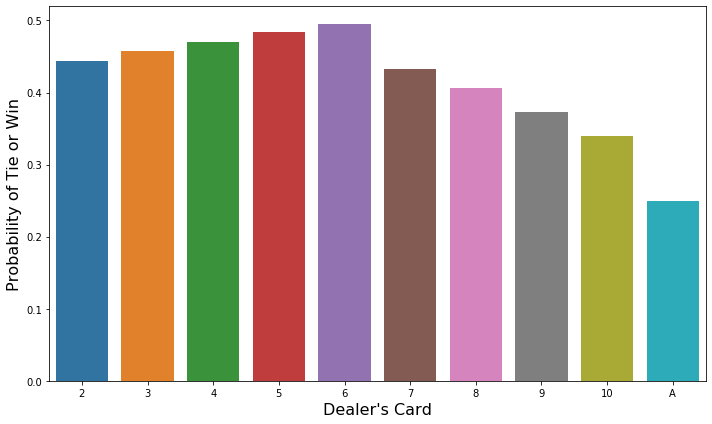

In [19]:
#From this we can see when the dealer has 6 in his card, he has the highest winning probability 48%
#when the dealer has A in his hand, the probiliby is the smallest
# bust 
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data.index, y=data.values)

ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.tight_layout()
plt.savefig(fname='dealer_card_probs', dpi=150)

In [20]:
data = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
            model_df.groupby(by='player_total_initial').count()['lose'])

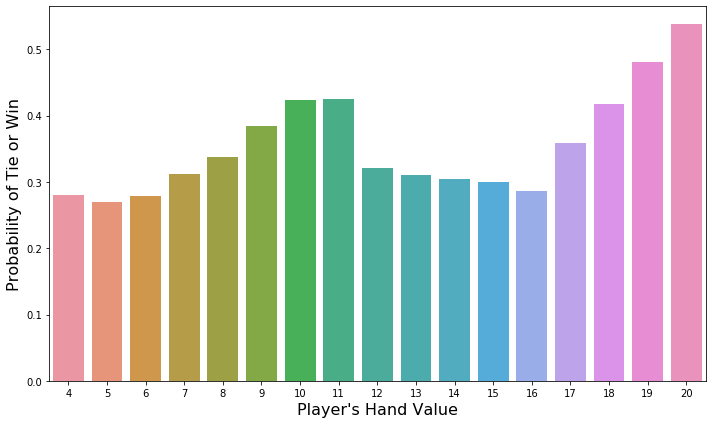

In [21]:
#when the player hand value is 19, 20 has the higher winning probality
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
plt.savefig(fname='player_hand_probs', dpi=150)

In [22]:
#when the player does not have ace the winner probability is higher?
model_df.groupby(by='has_ace').sum()['lose'] / model_df.groupby(by='has_ace').count()['lose']

has_ace
0    0.644167
1    0.362290
Name: lose, dtype: float64

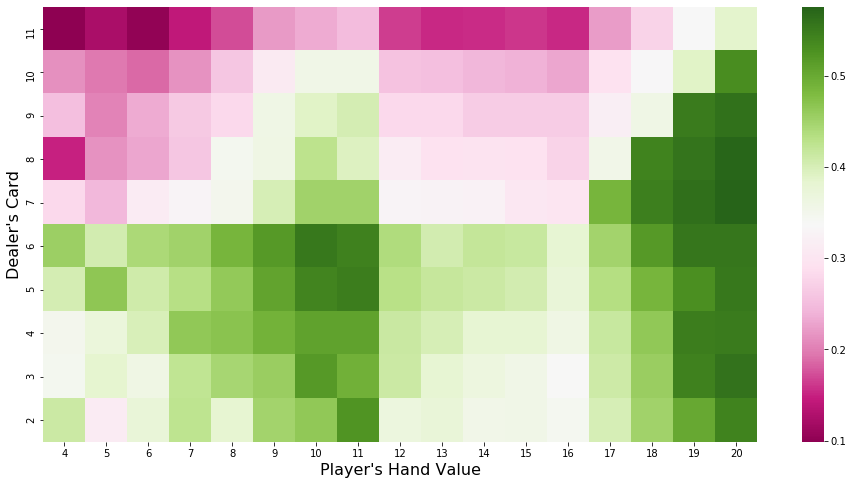

In [23]:
pivot_data = model_df[model_df['player_total_initial'] != 21]

losses_pivot = pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = np.sum)

games_pivot =  pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = 'count')

heat_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(heat_data, square=False, cmap="PiYG");

ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Dealer's Card",fontsize=16)

plt.savefig(fname='heat_map_random', dpi=150)

In [24]:
stacks = 10000
players = 1
num_decks = 4

# a different strategy 
# Hit only when we know we will not bust hit when we know our hand value is not than 11 

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_results = []
player_live_action = []


for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = generate_decks(num_decks, card_types)

    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        player_aces = [[] for player in range(players)]

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            if(dealer_cards[-1] == 'A'):
                player_aces[player].append(1)
                player_hands[player].append(dealer_cards.pop(0))
            else:
                player_aces[player].append(0)
                player_hands[player].append(dealer_cards.pop(0))       
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            if(dealer_cards[-1] == 'A'):
                player_aces[player].append(1)
                player_hands[player].append(dealer_cards.pop(0))
            else:
                player_aces[player].append(0)
                player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        action = 0

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    dealer_first_hand = 0
                    if dealer_hand[0] == 'A':
                        dealer_first_hand = 10
                    else:
                        dealer_first_hand = dealer_hand[0]
                        
                    # smart strategy
                    if dealer_first_hand > 7 and sum_up(player_hands[player]) < 13:
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                    elif dealer_first_hand > 8 and sum_up(player_hands[player]) < 14:
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                    elif dealer_first_hand < 12:
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                    elif dealer_first_hand > 7 and sum_up(player_hands[player]) < 19 and player_aces[player] > 0:
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                    elif sum_up(player_hands[player]) > 21:
                        curr_player_results[0,player] = -1
                        break
                    
                     # Hit only when we know we will not bust
#                     while sum_up(player_hands[player]) <= 11:
#                         player_hands[player].append(dealer_cards.pop(0))
#                         action = 1
#                         if sum_up(player_hands[player]) > 21:
#                             curr_player_results[0,player] = -1
#                             break

        
        # Dealer hits based on the rules
        while sum_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if sum_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if sum_up(player_hands[player]) > sum_up(dealer_hand):
                    if sum_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif sum_up(player_hands[player]) == sum_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_action.append(action)
    
model_df_naive_modified = pd.DataFrame()
model_df_naive_modified['dealer_card'] = dealer_card_feature
model_df_naive_modified['player_total_initial'] = [sum_up(i[0][0:2]) for i in player_card_feature]
model_df_naive_modified['player_result'] = [i[0] for i in player_results]
model_df_naive_modified['hit?'] = player_live_action

lose = []
for i in model_df_naive_modified['player_result']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_naive_modified['lose'] = lose

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_naive_modified['has_ace'] = has_ace

dealer_card_num = []
for i in model_df_naive_modified['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df_naive_modified['dealer_card_num'] = dealer_card_num

correct = []  #correct action 
for i, val in enumerate(model_df_naive_modified['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df_naive_modified['correct_action'] = correct

In [25]:
model_df_naive_modified.head()

,dealer_card,player_total_initial,player_result,hit?,lose,has_ace,dealer_card_num,correct_action
0,3,12,-1.0,1,1,0,3,0
1,5,16,0.0,1,0,0,5,1
2,10,19,1.0,1,0,0,10,1
3,10,19,0.0,1,0,0,10,1
4,5,15,1.0,1,0,0,5,1


In [26]:
naive_modified_win_possibility = 1 - (model_df_naive_modified.sum()['lose'] /\
                  model_df_naive_modified.count()['lose'])
print(naive_modified_win_possibility)

0.722187646818351


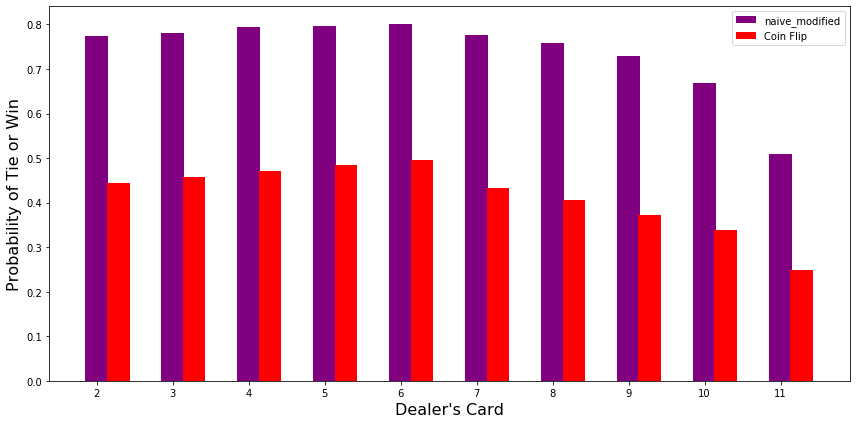

In [27]:
# As we can see use some strategy, we can see that the winning probability has increased
# data_naive = 1 - (model_df_naive.groupby(by='dealer_card_num').sum()['lose'] /\
#                   model_df_naive.groupby(by='dealer_card_num').count()['lose'])
data_naive_modified = 1 - (model_df_naive_modified.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_naive_modified.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])

data = pd.DataFrame()
# data['naive'] = data_naive
data['naive_modified'] = data_naive_modified
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
# ax.bar(x=data.index-0.28, height=data['naive'].values, color='blue', width=0.3, label='naive')
ax.bar(x=data.index, height=data['naive_modified'].values, color='purple', width=0.3, label='naive_modified')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='dealer_card_probs_naive', dpi=150)

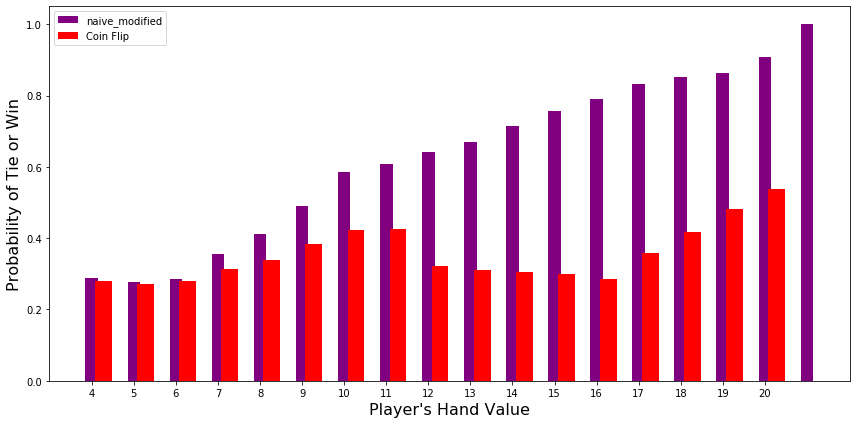

In [28]:
#winning probability has increased
# data_naive = 1 - (model_df_naive.groupby(by='player_total_initial').sum()['lose'] /\
#                   model_df_naive.groupby(by='player_total_initial').count()['lose'])
data_naive_modified = 1 - (model_df_naive_modified.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_naive_modified.groupby(by='player_total_initial').count()['lose'])
data_random = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
                   model_df.groupby(by='player_total_initial').count()['lose'])

data = pd.DataFrame()
# data['naive'] = data_naive[:-1]
data['naive_modified'] = data_naive_modified
data['random'] = data_random[:-1]

fig, ax = plt.subplots(figsize=(12,6))
# ax.bar(x=data.index-0.28, height=data['naive'].values, color='blue', width=0.3, label='naive')
ax.bar(x=data.index, height=data['naive_modified'].values, color='purple', width=0.3, label='naive_modified')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.4, label='Coin Flip')
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='player_hand_probs_naive', dpi=150)

In [29]:
feature_list_modified = [i for i in model_df_naive_modified.columns if i not in ['dealer_card',
                                                         'player_result','lose',
                                                         'correct_action']]
print(feature_list_modified)
train_X_modified = np.array(model_df_naive_modified[feature_list_modified])
train_Y_modified = np.array(model_df_naive_modified['correct_action']).reshape(-1,1)  #is our target 
print(train_X_modified)

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']
[[12  1  0  3]
 [16  1  0  5]
 [19  1  0 10]
 ...
 [ 8  1  0  4]
 [13  1  0  5]
 [13  1  0  6]]


In [30]:
train_Y_modified.shape

(327786, 1)

In [31]:
model_modified = Sequential()
model_modified.add(Dense(16))
model_modified.add(Dense(32))
model_modified.add(Dense(16))
model_modified.add(Dense(8))
model_modified.add(Dense(1, activation='sigmoid'))  #activation layer activation func 'sigmoid'
model_modified.compile(loss='binary_crossentropy', optimizer='sgd')
model_modified.fit(train_X_modified, train_Y_modified, epochs=10, batch_size=32, verbose=1) 
pred_Y_train_modified = model_modified.predict(train_X_modified)
actuals_modified = train_Y_modified[:,-1]


Epoch 1/10
327786/327786 [==============================] - 16s 49us/step - loss: 0.4992
Epoch 2/10
327786/327786 [==============================] - 14s 43us/step - loss: 0.4847
Epoch 3/10
327786/327786 [==============================] - 15s 46us/step - loss: 0.4831
Epoch 4/10
327786/327786 [==============================] - 15s 45us/step - loss: 0.4823
Epoch 5/10
327786/327786 [==============================] - 15s 45us/step - loss: 0.4819
Epoch 6/10
327786/327786 [==============================] - 15s 45us/step - loss: 0.4816
Epoch 7/10
327786/327786 [==============================] - 15s 45us/step - loss: 0.4813
Epoch 8/10
327786/327786 [==============================] - 15s 46us/step - loss: 0.4811
Epoch 9/10
327786/327786 [==============================] - 15s 45us/step - loss: 0.4810
Epoch 10/10
327786/327786 [==============================] - 15s 45us/step - loss: 0.4809


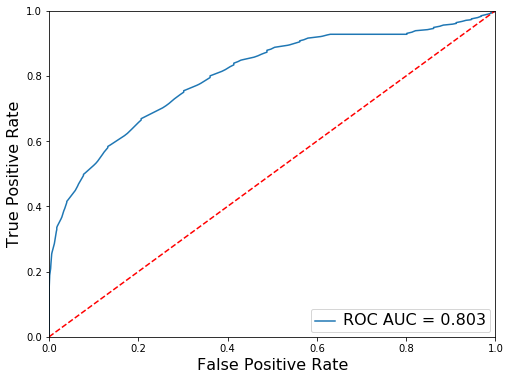

In [32]:
fpr, tpr, threshold = metrics.roc_curve(actuals_modified, pred_Y_train_modified)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)

plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()

In [33]:
#train_X train_Y
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(16, 32, 8),max_iter=10000, verbose=10)


In [34]:
feature_list_test = [i for i in model_df_naive_modified.columns if i not in ['dealer_card',
                                                         'player_result','lose',
                                                         'correct_action']]
print(feature_list_test)
train_X_test = np.array(model_df_naive_modified[feature_list_test])
train_Y_test = np.array(model_df_naive_modified['correct_action']).reshape(-1,1)  #is our target 
print(train_X_test)

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']
[[12  1  0  3]
 [16  1  0  5]
 [19  1  0 10]
 ...
 [ 8  1  0  4]
 [13  1  0  5]
 [13  1  0  6]]


In [35]:
mlp.fit(train_X_test, train_Y_test)

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.45958058
Iteration 2, loss = 0.41375737
Iteration 3, loss = 0.41089043
Iteration 4, loss = 0.40939216
Iteration 5, loss = 0.40898736
Iteration 6, loss = 0.40837516
Iteration 7, loss = 0.40826313
Iteration 8, loss = 0.40775836
Iteration 9, loss = 0.40772651
Iteration 10, loss = 0.40738584
Iteration 11, loss = 0.40726243
Iteration 12, loss = 0.40710833
Iteration 13, loss = 0.40678206
Iteration 14, loss = 0.40697770
Iteration 15, loss = 0.40689355
Iteration 16, loss = 0.40661184
Iteration 17, loss = 0.40653800
Iteration 18, loss = 0.40644687
Iteration 19, loss = 0.40636370
Iteration 20, loss = 0.40616879
Iteration 21, loss = 0.40600961
Iteration 22, loss = 0.40595278
Iteration 23, loss = 0.40570086
Iteration 24, loss = 0.40569623
Iteration 25, loss = 0.40553768
Iteration 26, loss = 0.40548094
Iteration 27, loss = 0.40538219
Iteration 28, loss = 0.40527025
Iteration 29, loss = 0.40503710
Iteration 30, loss = 0.40493667
Iteration 31, loss = 0.40505574
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 32, 8), learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=10, warm_start=False)

In [36]:
print('Test accuracy', mlp.score(train_X_test,train_Y_test))

Test accuracy 0.7974135564057038


In [37]:
# and then based on that prediction, 
# use this model to predict the action 

def model_decision(model, player_sum, has_ace, dealer_card_num):
    input_array = np.array([player_sum, 0, has_ace, dealer_card_num]).reshape(1,-1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.50:
        return 1
    else:
        return 0

In [38]:
# Play blackjack but use the neural net to make hit/stay decision

stacks = 10000
players = 1
num_decks = 4

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = generate_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        # Record the player's live total after cards are dealt
        live_total.append(sum_up(player_hands[player]))
        action = 0

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    # Neural net decides whether to hit or stand
                    if 'A' in player_hands[player][0:2]:
                        ace_in_hand = 1
                    else:
                        ace_in_hand = 0
                    if dealer_hand[0] == 'A':
                        dealer_face_up_card = 11
                    else:
                        dealer_face_up_card = dealer_hand[0]
                    
                    while (model_decision(model_modified, sum_up(player_hands[player]), 
                                          ace_in_hand, dealer_face_up_card) == 1) and (sum_up(player_hands[player]) != 21):
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                        live_total.append(sum_up(player_hands[player]))
                        if sum_up(player_hands[player]) > 21:
                            curr_player_results[0,player] = -1
                            break
        
        # Dealer hits based on the rules
        while sum_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if sum_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if sum_up(player_hands[player]) > sum_up(dealer_hand):
                    if sum_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif sum_up(player_hands[player]) == sum_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)

model_df_smart = pd.DataFrame()
model_df_smart['dealer_card'] = dealer_card_feature
model_df_smart['player_total_initial'] = [sum_up(i[0][0:2]) for i in player_card_feature]
model_df_smart['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_smart['has_ace'] = has_ace

dealer_card_num = []
for i in model_df_smart['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df_smart['dealer_card_num'] = dealer_card_num

model_df_smart['player_result'] = [i[0] for i in player_results]
lose = []
for i in model_df_smart['player_result']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_smart['lose'] = lose

In [39]:
model_df_smart

,dealer_card,player_total_initial,hit?,has_ace,dealer_card_num,player_result,lose
0,7,21,0,1,7,1.0,0
1,5,12,1,0,5,-1.0,1
2,9,10,1,0,9,1.0,0
3,5,6,0,0,5,-1.0,1
4,4,20,1,0,4,-1.0,1
...,...,...,...,...,...,...,...
321437,4,12,1,0,4,-1.0,1
321438,7,13,1,0,7,-1.0,1
321439,2,14,1,0,2,-1.0,1
321440,3,11,1,0,3,-1.0,1


In [40]:
smart_win_possibility = 1 - (model_df_smart.sum()['lose'] /\
                  model_df_smart.count()['lose'])
print(smart_win_possibility)

0.21658961803373544


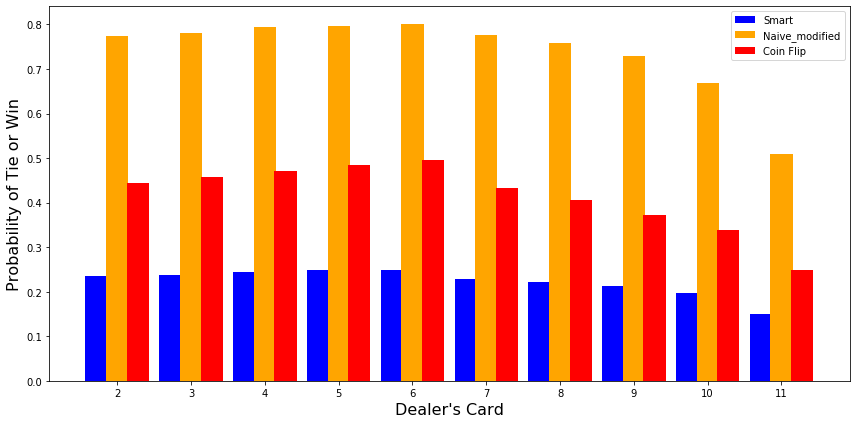

In [41]:
data_smart = 1 - (model_df_smart.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_smart.groupby(by='dealer_card_num').count()['lose'])
data_naive_modified = 1 - (model_df_naive_modified.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_naive_modified.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart
data['naive_modified'] = data_naive_modified
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.28, height=data['smart'].values, color='blue', width=0.3, label='Smart')
ax.bar(x=data.index, height=data['naive_modified'].values, color='orange', width=0.3, label='Naive_modified')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
#plt.savefig(fname='dealer_card_probs_smart', dpi=150)